# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

# Цель
Проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv("/datasets/real_estate_data.csv", sep = '\t' )
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

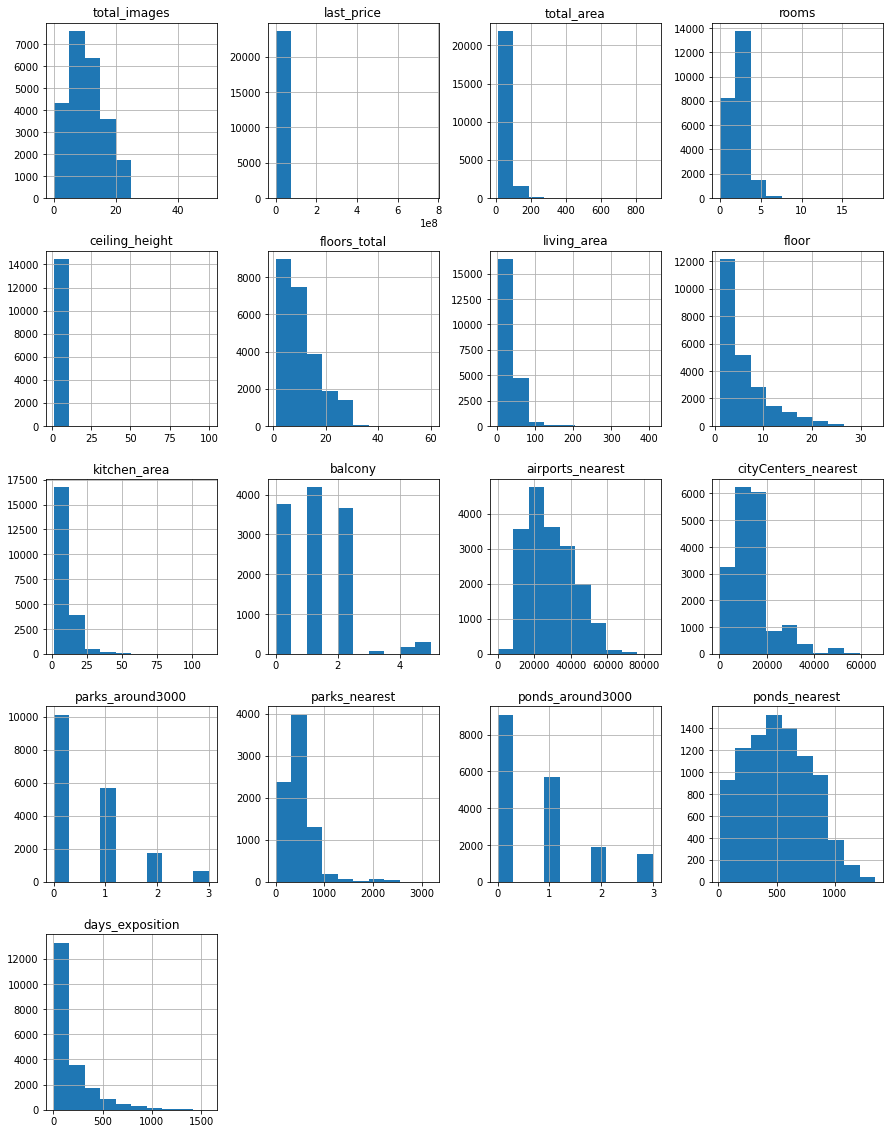

In [2]:
data.hist(figsize = (15,20))
plt.show()


В многих графиках мы можем с ходу заметить выбросы, в таких как: last_price, total_area, rooms, ceiling_height, living_area, kitchen_area

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Выполните предобработку данных

Возможные причины пропусков:

`balcony`: NA - значит его нет, заменим на ноль (так как тут пишут именно количество балконов)

`is_aparment`: NA - значит это не апартаменты, заменим на False

`kitchen_area`: NA - значит там нет кухонной территории, заменим на медианное значение (так как это кв.м, следовательно замена на ноль может слишком сильно изменить наше распределение)

`ceiling_height`: пропуски могут быть вызваны тем, что или продавец не указал, или при
выгрузке данных были повреждены. Заменим на медианное безболезненно (по тем же причинам)

`floors_total`: мало пропусков - удалим безболезненно
По остальным сложно сделать какие-либо выводы, оставим в них пропуски.


Возможные причины пропусков:
    
`balcony`: NA - значит его нет, заменим на ноль (так как тут пишут именно количество балконов)

`is_aparment`: NA - значит это не апартаменты, заменим на False

`kitchen_area`: NA - значит там нет кухонной территории, заменим на медианное значение или на более сложную
метрику (так как это кв.м, следовательно замена на ноль может слишком сильно изменить наше распределение)

`ceiling_height`: пропуски могут быть вызваны тем, что или продавец не указал, или при
выгрузке данных были повреждены. Заменим на медианное безболезненно (по тем же причинам)

`floors_total`: мало пропусков - удалим безболезненно

`living_area`: скорей всего пропуски могут быть вызваны банально тем, что далеко не во всех объявлениях это вообще указывают

`locality_name`: Очень мало пропусков - думаю логично не обращать внимание на данные значения

 Пропуски в таких показателях, как: `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` скорей всего вызваны двумя факторами: автор не указывал данные значения, утеря данных при выгрузке или обработке.
 
`days_exposition`: пропуски могли быть вызваны потерей во время выгрузке или ошибки при форматировании




In [4]:
data['balcony'] = data['balcony'].fillna(0)

data['is_apartment'] = data['is_apartment'].fillna(False)
 
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

data = data.dropna(subset = ['floors_total'])


# В остальных полях слишком много пропусков, заменив на какое то одно значение мы слишком сильно можем изменить выборку
# так что не будем их менять

In [5]:
# Найдем примерное значение кухонной площади относительно общей площади квартиры

data['df_depends_kitchen_total'] = data['kitchen_area']/data['total_area']
parametr = data['df_depends_kitchen_total'].mean()

In [6]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*parametr)

In [7]:
print(data.isna().sum())

total_images                    0
last_price                      0
total_area                      0
first_day_exposition            0
rooms                           0
ceiling_height                  0
floors_total                    0
living_area                  1870
floor                           0
is_apartment                    0
studio                          0
open_plan                       0
kitchen_area                    0
balcony                         0
locality_name                  48
airports_nearest             5532
cityCenters_nearest          5509
parks_around3000             5508
parks_nearest               15568
ponds_around3000             5508
ponds_nearest               14552
days_exposition              3172
df_depends_kitchen_total     2231
dtype: int64


Исправляем типы данных

Поясним почему для того или иного поля я выбрал тот или иной тип данных:

first_day_exposition - поменяем на дату (так как это дата, а не просто строка)
floors_total - поменяем с float на int, так как у нас не может быть дробного количества этажей
is_apartment - здесь у нас только два значения - TRUE or FALSE, следовательно, можно сделать вывод, что это булевый тип данных
balcony - поменяем с float на int, так как у нас не может быть дробного количества балконов
parks_around3000 - поменяем с float на int, так как у нас не может быть дробного количества парковок
days_exposition - поменяем с float на int, так как у нас не может быть дробного количества дней

In [8]:

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y.%m.%d')

data['floors_total'] = data['floors_total'].astype('int')

data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int', errors = 'ignore')
data['days_exposition'] = data['days_exposition'].astype('int', errors = 'ignore')


Неявные дубликаты

Создадим функцию, которая будет приводить к одному виду, такие вещи как: "поселок" и "посёлок"

In [9]:

data['locality_name'] = data['locality_name'].str.replace('ё','е')

In [10]:
def func_(i):
    if type(i) != float:
        if i != i.split('поселок городского типа ')[0]:
            return 'поселок ' + str(i.split('поселок городского типа ')[1])  
        if i != i.split('городской поселок ')[0]:
            return 'поселок ' + str(i.split('городской поселок ')[1])  
        if i != i.split('коттеджный поселок ')[0]:
            return 'поселок ' + str(i.split('коттеджный поселок ')[1])  
    return i

data['locality_name'] = data['locality_name'].apply(func_)

In [11]:
#Проверим:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'деревня Федоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок Ефимовский', 'поселок Плодовое', 'деревня Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено


### Промежуточный вывод по предаброботке:
    
    1) Заменил пропуски по логическим соображениям, например: балконы или принадлежность к типу 
        апартаменты (их отсутствие), удалил количество этажей (в силу маленького количества выбросов),
        заменил высоту потолков на медианное значение, а вот говоря о пропусках с плоащдью кухни - решил взять 
        среднее значение доли площади кухни от площади всей квартиры в общем
    2) Некоторые пропуски пришлось оставить без изменения в виду очень большого колчисетва выбросов

### Добавьте в таблицу новые столбцы


    
    Добавил столбцы, рассчитав метрика за кв. метр путем деление цены на площадь всей кв
    Также отделил день недели, месяц, год у даты публикации
    И поделил этажность на типы: первый, последний, другой
    

In [12]:
data['per_meter'] = round(data['last_price']/data['total_area'],2)
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year
def type_(str_):
    if str_['floors_total'] == str_['floor']:
        return 'последний'
    if str_['floor'] == 1:
        return 'первый'
    return 'другой'
data['foor_type'] = data.apply(type_,axis = 1)
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round() 


### Проведите исследовательский анализ данных

Избавимся от выбросов

In [13]:
data['last_price'].mean()
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'деревня Федоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок Ефимовский', 'поселок Плодовое', 'деревня Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

Исследуя график цены объекта, можно увидеть, что основная масса находится до 70 млн
Удалим данные значения безболезненно

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

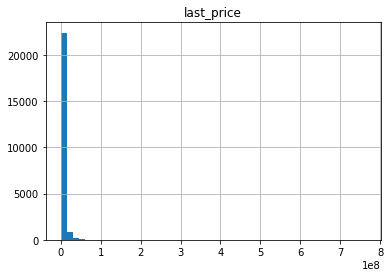

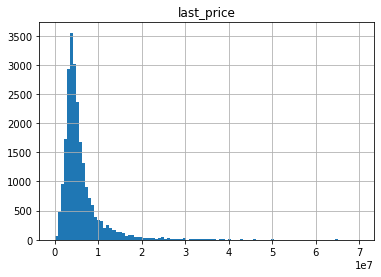

In [14]:

data.hist('last_price', bins = 50)
data.hist('last_price', bins = 100,range = (0,70000000))


In [15]:
data = data.query('last_price < 70000000')

Большинство квартир имеют площади до 300 кв

array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

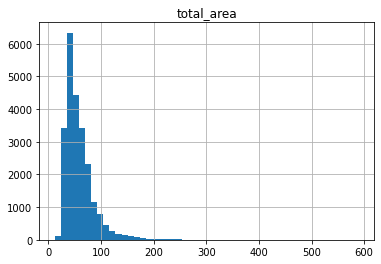

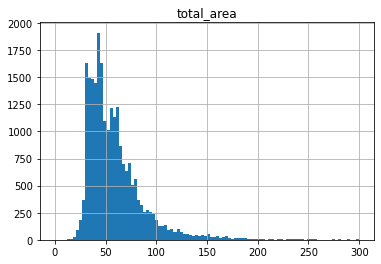

In [16]:
data.hist('total_area', bins = 50)
data.hist('total_area', bins = 100,range = (0,300))


In [17]:
data = data.query('total_area < 300')

Большинство значений находятся до 150

array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

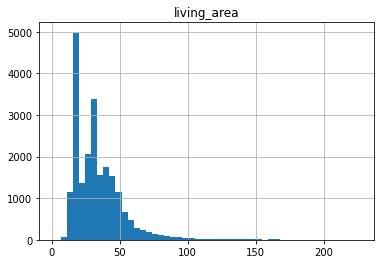

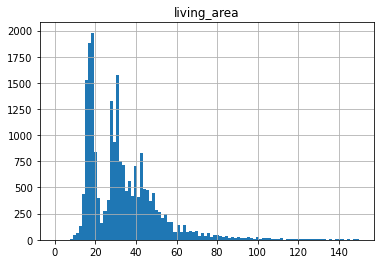

In [18]:
data.hist('living_area', bins = 50)
data.hist('living_area', bins = 100,range = (0,150))

In [19]:
data = data.query('living_area < 150') 

Большинство значений расположилось до 50 кв

array([[<AxesSubplot:title={'center':'kitchen_area'}>]], dtype=object)

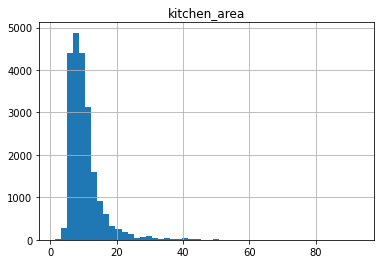

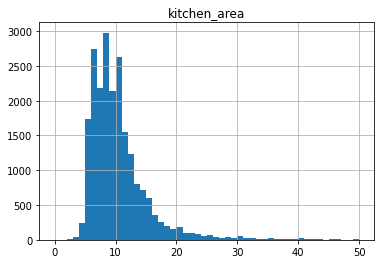

In [20]:

data.hist('kitchen_area', bins = 50)
data.hist('kitchen_area', bins = 50,range = (0,50))

In [21]:
data = data.query('kitchen_area < 50')


Удалили выбросы - стало лучше видно распределение

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

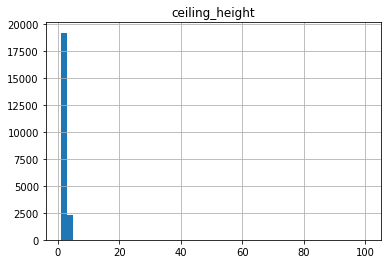

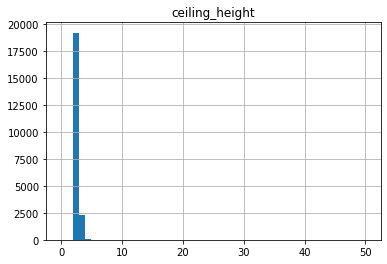

In [22]:

data.hist('ceiling_height', bins = 50)
data.hist('ceiling_height', bins = 50,range = (0,50))


Сместим плавующую точку анамалии 

In [23]:

def ceil_height(i):
    if i > 20:
        return i/10
    return i
data['ceiling_height'] = data['ceiling_height'].apply(ceil_height)


 Большинство значений до 5 м

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

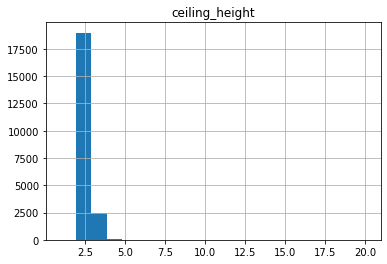

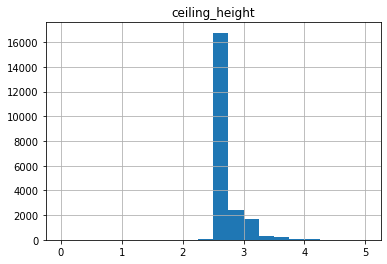

In [24]:
data.hist('ceiling_height', bins = 20)
data.hist('ceiling_height', bins = 20,range = (0,5))


    Можно заметить, что, на самом деле, самый частый показатель - между 2 и 3 метрами

In [25]:
data = data.query('ceiling_height < 5')

Основная масса значений находится до 8
Анамалия в виде 0 комнат может быть вызвана тем, что в студиях "как бы ноль комнат"

array([[<AxesSubplot:title={'center':'rooms'}>]], dtype=object)

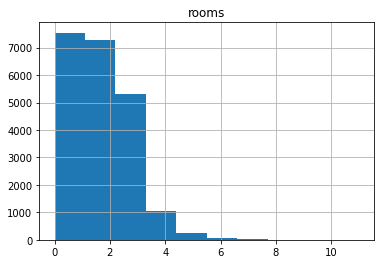

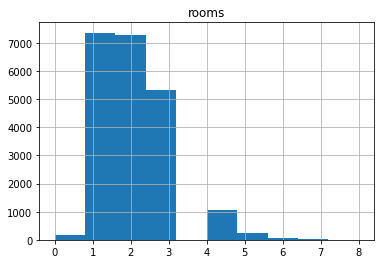

In [26]:
data.hist('rooms', bins = 10)
data.hist('rooms', bins = 10,range = (0,8))

In [27]:
data = data.query('rooms < 8')

Большинство значение - до 40 этажей

array([[<AxesSubplot:title={'center':'floors_total'}>]], dtype=object)

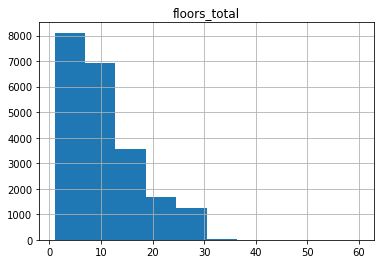

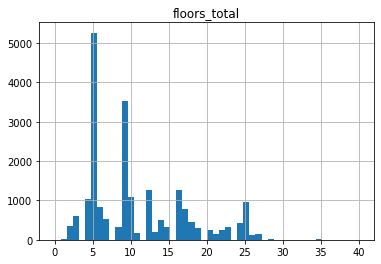

In [28]:

data.hist('floors_total', bins = 10)
data.hist('floors_total', bins = 50 ,range = (0,40))

In [29]:
data = data.query('floors_total < 40')

В данных случаях ничего не надо ограничивать, сильных выбрасов не видно

array([[<AxesSubplot:title={'center':'cityCenters_nearest'}>]],
      dtype=object)

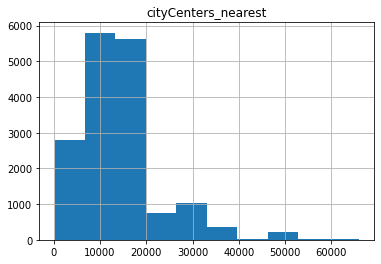

In [30]:
data.hist('cityCenters_nearest', bins = 10)


 Сильных выбросов я тут не вижу. Самые поплуярные значенния расположились около 500 метров

array([[<AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

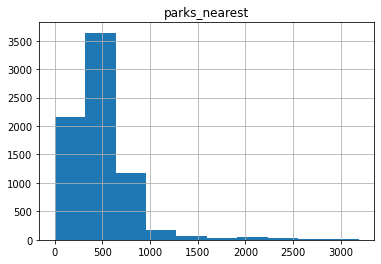

In [31]:
data.hist('parks_nearest', bins = 10)


Видно, что первый и последний имеют почти одинаковую популярность на пулах с объявлениями

<AxesSubplot:>

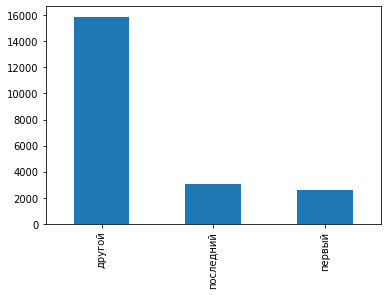

In [32]:
pi_tb_floor_type = data['foor_type'].value_counts()
pi_tb_floor_type.plot(kind = 'bar')

Будем считать продажи, которые длились больше 1000 (трех лет) - как анамалия
Причина этому может стать - забытое автором снятие публикации 


медиана: 100.0
среднее: 183.87940860215053


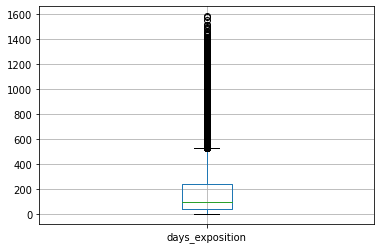

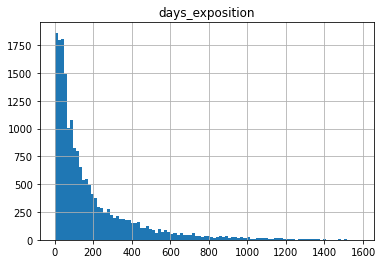

In [33]:
data.boxplot('days_exposition')
data.hist('days_exposition', bins = 100)
l = data['days_exposition'].describe()
print(f'медиана: {data["days_exposition"].median()}')
print(f'среднее: {data["days_exposition"].mean()}')


In [34]:
# отметим быстрые продажи
too_slow = data.query ('days_exposition > 1000')

<AxesSubplot:title={'center':'Быстрые продажи'}, ylabel='Frequency'>

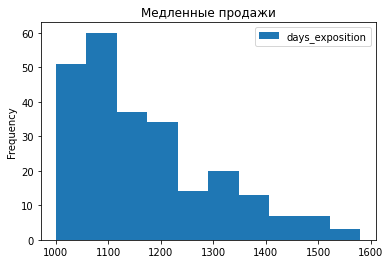

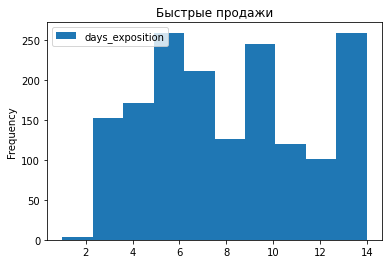

In [35]:
# отметим медленные продажи
too_fast = data.query ('days_exposition < 15')
too_slow.plot(y = 'days_exposition',kind = 'hist', title = 'Медленные продажи')
too_fast.plot(y = 'days_exposition',bins = 10,kind = 'hist', title = 'Быстрые продажи')



В силу распределения - будем считать быстрые продажи -  меньше 15 дней
    А медленные продажи - больше 1000 дней (почти больше трех лет)


после 1100 дней начинает снижатья количество медленный публикаций

<AxesSubplot:>

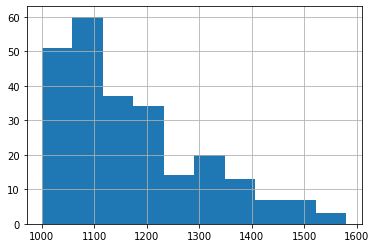

In [36]:
too_slow['days_exposition'].hist()


Меньше двух дней - почти нет
Зато порядка 250 объявлений квартир было продано за какие-то от 6 - 14 дней
Можно, наверное, порассуждать почему на 6-ой и 13-ые дни чаще продается (может связано с днем недели)

<AxesSubplot:>

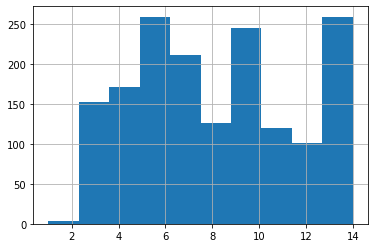

In [37]:
too_fast['days_exposition'].hist()

Построив графики, видно, что самая сильная зависимость от площади в квартире в целом. Чуть меньше прослеживается зависимость от жилой площади и кухонной (однако причина этоу могут быть пропуски!)
Дальше можно увидеть положительную зависимость от количества комнат

А вот относительно этажа можно сказать, что первый этаж чуть-чуть дешевле!

Зависимости от дня недели и месяца публикации - нет

От года чуть-чуть больше чем от месяца, но зависимость так же очень слабая

Говоря о типе этажа, можно увидеть зависимость того, что последний и первый часто дешевле чем все остальные

0.7581306925729604 total_area
0.6553424010158555 living_area
0.5696809782259991 kitchen_area


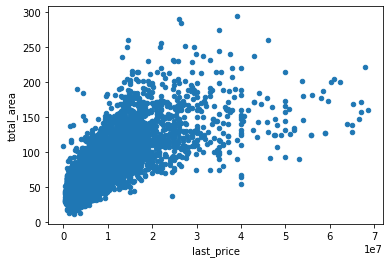

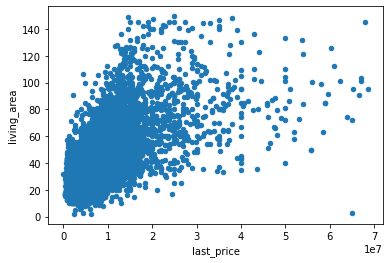

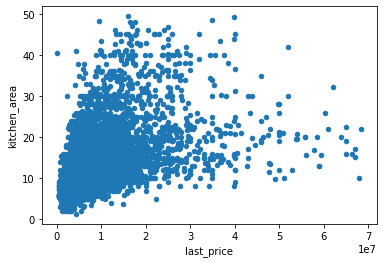

In [38]:
data.plot(x = 'last_price', y = 'total_area', kind = 'scatter')
print(data[ 'last_price'].corr(data['total_area']), 'total_area')
data.plot(x = 'last_price', y = 'living_area', kind = 'scatter')
print(data['last_price'].corr(data['living_area']),'living_area')
data.plot(x = 'last_price', y = 'kitchen_area', kind = 'scatter')
print(data['last_price'].corr(data['kitchen_area']),'kitchen_area')



Присутсвует явная положительная зависимость

<AxesSubplot:xlabel='rooms'>

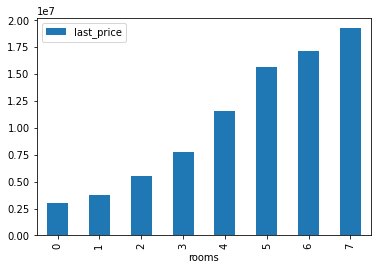

In [39]:
df_rooms = data.pivot_table(index = 'rooms', values = 'last_price',aggfunc = 'mean')
df_rooms.plot(kind = 'bar')


Во всех трех графиках слонжо увидеть явную зависимость

<AxesSubplot:xlabel='exposition_year'>

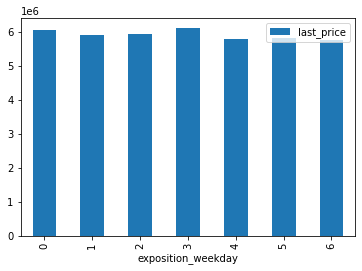

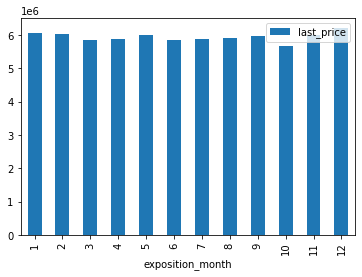

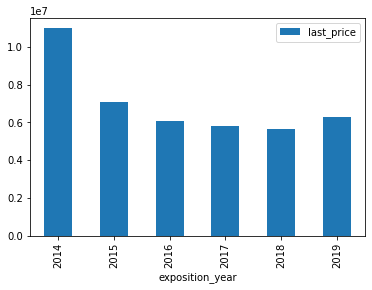

In [40]:

df_exposition_weekday = data.pivot_table(index = 'exposition_weekday', values = 'last_price',aggfunc = 'mean')
df_exposition_weekday.plot(kind = 'bar')

df_exposition_month = data.pivot_table(index = 'exposition_month', values = 'last_price',aggfunc = 'mean')
df_exposition_month.plot(kind = 'bar')

df_exposition_year = data.pivot_table(index = 'exposition_year', values = 'last_price',aggfunc = 'mean')
df_exposition_year.plot(kind = 'bar')



Самые дорогие населенные пункты за кв. метр - это Санкт-Петербург, Пушкин, Деревня Кудрово
Самые дешевые - Всеволжск, Гатчина, Колпино

In [41]:
data['locality_name'].value_counts().sort_values(ascending=False).head(10)

Санкт-Петербург      14337
поселок Мурино         491
поселок Шушары         403
Всеволожск             371
Пушкин                 340
Колпино                327
поселок Парголово      301
Гатчина                292
деревня Кудрово        262
Петергоф               197
Name: locality_name, dtype: int64

In [42]:
p = data.pivot_table(index = 'locality_name', values = 'per_meter', aggfunc = ['count','mean'])
p.columns = ['count', 'mean']
p = pd.DataFrame(p.sort_values(by = 'count', ascending = False))
p = p.loc[:p.index[9], :]
p['mean'] = round(p['mean'],2)
p

,count,mean
locality_name,,
Санкт-Петербург,14337,112050.85
поселок Мурино,491,86308.48
поселок Шушары,403,78749.64
Всеволожск,371,68880.13
Пушкин,340,103222.95
Колпино,327,75249.78
поселок Парголово,301,90442.59
Гатчина,292,68627.36
деревня Кудрово,262,92702.18


<AxesSubplot:xlabel='locality_name'>

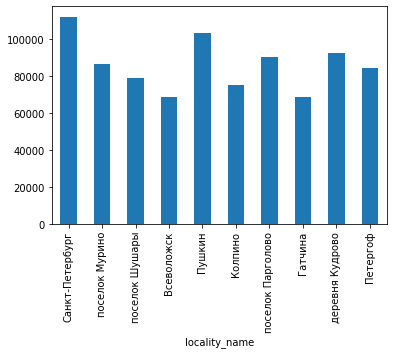

In [43]:
p['mean'].plot(kind = 'bar')

Можно с полной уверенностью сказать, что зависимость стоимость объекта от дальности от центра точно есть и она отрицательная (при больших значения отдаления - меньшая цена) 

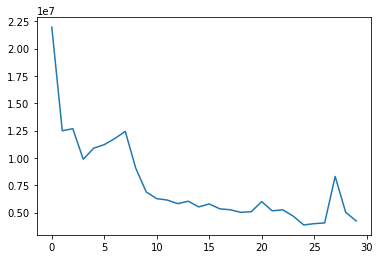

In [44]:
df = data.loc[data['locality_name'] == 'Санкт-Петербург',['cityCenters_nearest_km','last_price']]
df =pd.DataFrame(df.groupby('cityCenters_nearest_km').agg({'last_price':['mean']}))
df.columns = ['count']

plt.plot(df)


Можно с полной уверенностью сказать, что зависимость стоимость объекта от дальности от центра точно есть и она отрицательная (при больших значения отдаления - меньшая цена) 

### Напишите общий вывод


    
### Мы предобработали данные:
    1) Заменили пропуски на: ноль, на медианное значение
    2) Некоторые оставили в пропусках, да бы избежать большого изменения данных
    3) Обнаружили неявные дубликаты (по типу: поселок и посёлок) и устранили их
    
### Мы сформулировали некоторые новые метрики для исследования
    1) Добавили столбцы по дню недели, месяцу, году даты публикации
    2) Цена за квадратный метр
    3) Дальность от центра в км
    
### Мы построили графики зависимостей для разных метрик и вот что нам удалось выснить:
    1) Одна из самых сильных зависимостей стоимости объекта от квадратуры в общем,
    а также от квадратуры разных областей квартиры, таких как: жилая площаь, кухонная площадь
    
    2) Также мы заметили зависимость отдаления от центра, на примере Санкт-Петербурга (и она отрицательная)
    
    3) Выяснили, что зависимость стоимости от месяца и дня недели, года публикации объявления очень слабая (можно сказать, что ее нет)
    
    4) Если говорить про тип этажа,то, в основном,первый и последний дешевле остальных этажей
    
    5) В основном квартиры продаются за первые три месяца
    
    6) Цена квартиры имеет зависимость от количества комнат (положительную, экспоненциальную)
